In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import math

In [24]:
# SIZE = 31
SIZE = 21
DATA_PATH = "data/{}x{}".format(SIZE, SIZE)
 
wenames = [f"seed{i}/w_et" for i in [0,1]] 
genames = [f"seed{i}/g_et" for i in [0,1,2,3,4]]

correction_params = {"ptmean": False, "rotate": False, "transform_layers_together": True}
plot_params = {"log_color":False}

In [5]:
from scipy.optimize import minimize_scalar
import skimage.transform as ski

from matplotlib.colors import LogNorm

def show_images(images, log_color=False):
    fig = plt.figure()
    num_imgs = len(images)
#     axes = [fig.add_subplot(101 + n + 10*num_imgs, label=label) for n, label in enumerate(["Hadrons", "Leptons", "Total"])]
    axes = [fig.add_subplot(101 + n + 10*num_imgs) for n in range(num_imgs)]
    for image, axis in zip(images, axes):
        image = image + 0.001 # Fix logging of zeros
        if log_color:
            axis.imshow(image, norm=LogNorm(vmin=image.min(), vmax=image.max()))
        else:
            axis.imshow(image)
    plt.show()

def variance_angle(img, beta=1):
    # Turn the his,  togram into a set of points centred on the middle pixel
    x_max, y_max = img.shape
    points = np.asarray([[x-x_max/2 , y-y_max/2, img[int(x), int(y)]] 
                         for x in range(x_max)
                         for y in range(y_max)
                         if img[int(x), int(y)] > 0])
    mean_alpha = np.mean(np.arctan2(points[:,1] , (points[:,0])))
    return mean_alpha
    
def img_centre(img, ptmean=True):
    # Turn the histogram into a set of points centred on the middle pixel
    x_max, y_max = img.shape
    if ptmean:
        tot = np.sum(img)
        points = np.asarray([[(x-x_max/2) * img[int(x), int(y)] / tot,(y-y_max/2) * img[int(x), int(y)] / tot]
                             for x in range(x_max)
                             for y in range(y_max)])
        c_x, c_y = np.sum(points, axis=0)
        return c_x, c_y
    else:
        m_x, m_y = np.argwhere(img == np.max(img))[0]
        return math.ceil(m_x - x_max/2), math.ceil(m_y - y_max/2)
    
    
def correct_image(img, ptmean=True, rotate=True, transform_layers_together=True):
    # split image into layers
    if len(img.shape) > 2:
        layers = [img[:,:,i] for i in range(len(img[0,0,:]))]
    else:
        layers = [img]
        
    corrected = np.zeros(img.shape)
    
    if transform_layers_together:
        xc, yc = img_centre(img.sum(axis=2), ptmean)
        for i, layer in enumerate(layers):
            layers[i] = ski.warp(layer, ski.AffineTransform(translation=(1*yc, 1*xc)), order=0)
        if rotate:
            angle = (variance_angle(np.asarray(layers).sum(axis=0)) * 180/np.pi)
            for i, layer in enumerate(layers):
                layers[i] = ski.rotate(layer, -angle, order=0)
        for i, layer in enumerate(layers):
            corrected[:,:,i] = layer
        return corrected / np.sum(corrected)
    else:
        for i, layer in enumerate(layers):
            xc, yc = img_centre(layer, ptmean)
            layer = ski.warp(layer, ski.AffineTransform(translation=(1*yc, 1*xc)), order=0)
            if rotate:
                angle = (variance_angle(layer) * 180/np.pi)
                layer = ski.rotate(layer, -angle, order=0)
            corrected[:,:,i] = layer
        return corrected / np.sum(corrected)

def correct_series(series, **kwargs): 
    rotated = pd.Series(correct_image(series.values.reshape((SIZE,SIZE,2)), **kwargs).flatten())
    return rotated / rotated.sum()

In [6]:
w_et = (pd.concat([pd.read_csv(f"{DATA_PATH}/{name}.csv", header=None, dtype=np.float64)
                   for name in wenames])
          .dropna(1)
          .apply(correct_series, axis=1, **correction_params)
        )

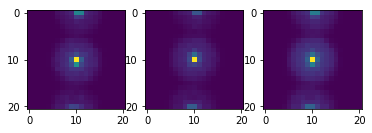

In [7]:
show_images([w_et.mean().values.reshape((SIZE,SIZE,2))[:,:,0].T,
             w_et.mean().values.reshape((SIZE,SIZE,2))[:,:,1].T,
             w_et.mean().values.reshape((SIZE,SIZE,2)).sum(axis=2).T],
             **plot_params)

In [8]:
g_et = (pd.concat([pd.read_csv(f"{DATA_PATH}/{name}.csv", header=None, dtype=np.float64)
                   for name in genames])
          .dropna(1)
          .apply(correct_series, axis=1, **correction_params)
        )

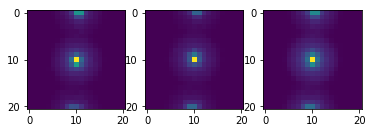

In [9]:
show_images([g_et.mean().values.reshape((SIZE,SIZE,2))[:,:,0].T,
             g_et.mean().values.reshape((SIZE,SIZE,2))[:,:,1].T,
             g_et.mean().values.reshape((SIZE,SIZE,2)).sum(axis=2).T],
            **plot_params)

In [10]:
limit = min([g_et.shape[0], w_et.shape[0]])
print("Gluon: {}; W: {};".format(g_et.shape[0], w_et.shape[0]))

Gluon: 76152; W: 43972;


In [17]:
from sklearn.model_selection import train_test_split

mean = pd.concat([g_et, w_et]).mean()
background = (g_et - mean).values
signal = (w_et - mean).values

X = np.r_[background, signal]
y = np.r_[np.zeros(len(background)),
          np.ones(len(signal))]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    shuffle=True, random_state=0)


In [18]:
import tensorflow as tf
import os

features = [tf.feature_column.numeric_column("x", shape=[SIZE,SIZE,2])]
dnn_clf = tf.estimator.DNNClassifier(hidden_units=[128, 256, 128], 
                                     n_classes=2,
                                     feature_columns=features)

train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": X_train.reshape((-1,SIZE,SIZE,2))},
        y=y_train,
        shuffle=False,
        batch_size=100
)

dnn_clf.train(input_fn=train_input_fn, steps=10000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Lewis\\AppData\\Local\\Temp\\tmp91n4xwif', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000019EA842A6A0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Checkp

In [21]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test.reshape((-1,SIZE,SIZE,2))},
    y=y_test,
    shuffle=False
)

y_test_pred = np.asarray([y["class_ids"] for y in dnn_clf.predict(test_input_fn)])
print("Precision: %0.2f" % precision_score(y_test, y_test_pred))
print("Recall: %0.2f" % recall_score(y_test, y_test_pred))
print("f1: %0.2f" % f1_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred, labels=[0, 1]) / len(y_test))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Lewis\AppData\Local\Temp\tmp91n4xwif\model.ckpt-1082
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Precision: 0.50
Recall: 0.27
f1: 0.35
[[0.53225672 0.0997253 ]
 [0.2681262  0.09989178]]


In [22]:
y_train_pred = np.asarray([y["class_ids"] for y in dnn_clf.predict(train_input_fn)])
print("Precision: %0.2f" % precision_score(y_train, y_train_pred))
print("Recall: %0.2f" % recall_score(y_train, y_train_pred))
print("f1: %0.2f" % f1_score(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred, labels=[0, 1]) / len(y_train))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Lewis\AppData\Local\Temp\tmp91n4xwif\model.ckpt-1082
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Precision: 0.51
Recall: 0.28
f1: 0.36
[[0.53513519 0.09902785]
 [0.26379369 0.10204327]]


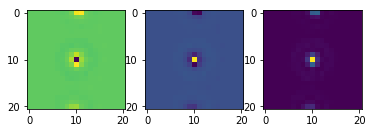

In [25]:
back_img = np.mean(background.reshape((-1,SIZE,SIZE,2)).sum(axis=3), axis=0).T
sig_img = np.mean(signal.reshape((-1,SIZE,SIZE,2)).sum(axis=3), axis=0).T
show_images([back_img,
             sig_img,
             np.abs(sig_img - back_img)],
           **plot_params)

In [19]:
from tensorflow.metrics import true_positives_at_thresholds, false_positives_at_thresholds
from sklearn.metrics import roc_curve

input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": X.reshape((-1,SIZE,SIZE,2))},
        y=y,
        shuffle=False
)


# Calculate rates for the signals
classes = [0, 1]
scores = np.asarray([y["probabilities"] for y in dnn_clf.predict(input_fn)])

fpr = {}
tpr = {}
for i in classes:
    fpr[i], tpr[i], _ = roc_curve(y, scores[:, i])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Lewis\AppData\Local\Temp\tmp91n4xwif\model.ckpt-1082
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


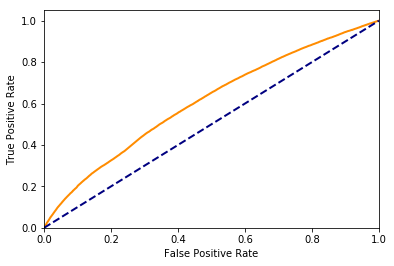

In [20]:
plt.figure()
plt.plot(fpr[1], tpr[1], color='darkorange', lw=2)
# plt.plot(fpr[0], tpr[0], color='green', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()